# HW 3
### Unsupervised Learning
#### Gian Zlupko

First, I import the wine data

In [3]:
import pandas as pd
import os

# change working directory 
os.chdir('/Users/gianzlupko/Desktop/GR5073 ML/gr5073_ML/data')

# read in the red and white wine data sets
red_wine = pd.read_csv("winequality-red.csv", sep = ';') 

# inspect the data 
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Next, I scale the data

In [9]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler() 
scaler.fit(red_wine)
wine_scaled = scaler.transform(red_wine)
 
# inspect data again to confirm that it was scaled 
print(wine_scaled)

[[-0.52835961  0.96187667 -1.39147228 -0.45321841 -0.24370669 -0.46619252
  -0.37913269  0.55827446  1.28864292 -0.57920652 -0.96024611 -0.78782264]
 [-0.29854743  1.96744245 -1.39147228  0.04341614  0.2238752   0.87263823
   0.62436323  0.02826077 -0.7199333   0.1289504  -0.58477711 -0.78782264]
 [-0.29854743  1.29706527 -1.18607043 -0.16942723  0.09635286 -0.08366945
   0.22904665  0.13426351 -0.33117661 -0.04808883 -0.58477711 -0.78782264]
 [ 1.65485608 -1.38444349  1.4841536  -0.45321841 -0.26496041  0.10759209
   0.41150046  0.6642772  -0.97910442 -0.46118037 -0.58477711  0.45084835]
 [-0.52835961  0.96187667 -1.39147228 -0.45321841 -0.24370669 -0.46619252
  -0.37913269  0.55827446  1.28864292 -0.57920652 -0.96024611 -0.78782264]]


#### 1. Use K Means Cluster Analysis to identify cluster(s) of observations that have high and low values of the wine quality. (Assume all variables are continuous.)

To determine an appropriate value for `k` clusters using k-means, I use the elbow curve method below. The elbow curve method plots the differences in within-group sum of squares (WGSS) for each cluster and the elbow in the curve is a heuristic used to identify a value of `k` clusters that substantially reduces WGSS. 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/clust

Text(0.5, 1.0, 'Elbow curve')

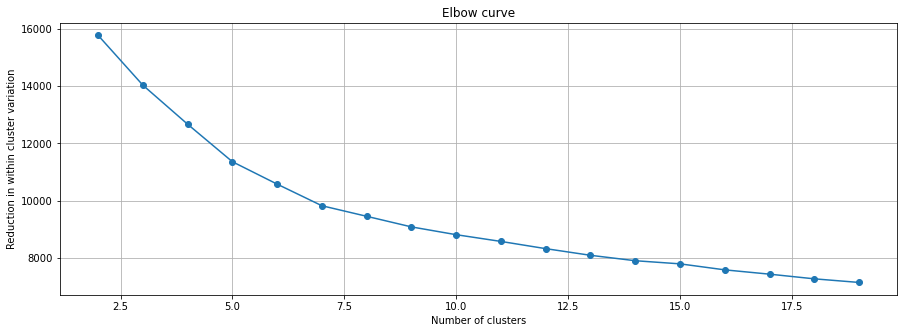

In [10]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

within_cluster_variance = [] # initiate empty list with no data

# build models for range of ks from 2 to 20
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(wine_scaled)
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), within_cluster_variance, marker='o')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Reduction in within cluster variation')

plt.title('Elbow curve')  #Choose k at elbow of plot as a general rule.  We want a small enough number of categories to 
                          # such that we can still learn something meaningful from them via exploration of our variables.